In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
torch.set_default_dtype(torch.float32)
from flumen import CausalFlowModel,TrunkNet, TrajectoryDataset
from flumen.utils import pack_model_inputs, plot_amari, trajectory,plot_space_time_flat_trajectory_V2
from torch.utils.data import DataLoader

from generate_data import make_trajectory_sampler

from argparse import ArgumentParser

import yaml
from pathlib import Path
import sys
from pprint import pprint
from time import time
import os
os.chdir("C:/Users/20192139/Documents/5ARG45 - Thesis/Code/FlowFunction/flumen")  # Change this to your actual path
import wandb
import pickle
from flumen import CausalFlowModel, print_gpu_info, TrajectoryDataset, TrunkNet
import torch
import seaborn as sns


In [4]:

def return_model(path):
    api = wandb.Api()
    model_artifact = api.artifact(path)
    model_path = Path(model_artifact.download())
    model_run = model_artifact.logged_by()
#     print(model_run.summary)
    device = "cpu"
    # Load model state dictionary
    with open(model_path / "state_dict.pth", 'rb') as f:
        state_dict = torch.load(f, map_location=torch.device("cpu"))  # Ensure compatibility

    with open(model_path / "metadata.yaml", 'r') as f:
        metadata: dict = yaml.load(f, Loader=yaml.FullLoader)
#     pprint(metadata)
#     print(metadata["args"])
    trunk_model = TrunkNet(in_size=256,out_size=100,hidden_size=metadata['args']['trunk_size_svd'],use_batch_norm=False)

    model = CausalFlowModel(**metadata["args"],trunk_model=trunk_model)
    model.load_state_dict(state_dict)
    model.eval()
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params}")
    return model

device = 'cpu'

## Kernel 1

In [9]:
test_data = torch.load("data/Brian2/gaussian_test.pt")
model_T2500 = "marijn-eindhoven-university-of-technology/Ablation/flow_model-brian_T2500_S100_LOOP-A_NL_100_L1:v54"
model_T90 = "marijn-eindhoven-university-of-technology/mu_1/flow_model-brian2_gaussian_T100-Scratch_T100_A_Nonlinear_100_L1:v30"
model_mu_2 = "marijn-eindhoven-university-of-technology/mu_1/flow_model-brian2_gaussian_T100-T90_mu2:v11"
model_mu_3 = "marijn-eindhoven-university-of-technology/mu_1/flow_model-brian2_gaussian_T100-T90_mu3:v29"
model_T2500 = return_model(model_T2500)
model_T90 = return_model(model_T90)
model_mu_2 = return_model(model_mu_2)
model_mu_3 = return_model(model_mu_3)
models = [model_T2500,model_T90,model_mu_2,model_mu_3]
    
all_losses_l1 = []
for model in models:
    model.to(device)
    trajectory_losses = []
    y_pred_flow = []
    for i in range(0,len(test_data['x0'])):
        with torch.no_grad():
            x0_feed = test_data['x0'][i]
            t_feed = test_data['t'][i]
            u_feed = test_data['u'][i]
            deltas_feed = test_data['deltas'][i]
            y_pred, basis_functions = model(x0_feed.to(device), u_feed.to(device),test_data['locations'].to(device),deltas_feed.to(device))
            y_pred_flow.append(y_pred.to('cpu').numpy())
    
    y_pred_flow = np.array(y_pred_flow)      
    
    losses_flow_total = []
    # iterate over trajectories
    for i in range(len(test_data['y'])):
        y = test_data['y'][i]
        y_pred_flow_i = np.flip(y_pred_flow[i], axis=0)
        losses_flow_total.append(np.mean(np.abs(y_pred_flow_i - y))) # L1
#         losses_flow_total.append(np.mean((y_pred_flow_i - y)**2)) # L2
    losses_flow_total = np.array(losses_flow_total)
    all_losses_l1.append(losses_flow_total)
    print('l1 flow: ', np.mean(losses_flow_total), "std: ", np.std(losses_flow_total))

WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_28840\967337786.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("data/Brian2/gaussian_te

True
Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1066351
l1 flow:  0.0377863633735937 std:  0.02455342483998703
l1 flow:  0.10857557014642671 std:  0.020924393135265788
l1 flow:  0.08284926041908937 std:  0.020042979666964757
l1 flow:  0.07376223568024684 std:  0.024699660401091676


In [ ]:
test_data = torch.load("data/Brian2/gaussian_test.pt")
model_T2500 = "marijn-eindhoven-university-of-technology/Ablation/flow_model-brian_T2500_S100_LOOP-A_NL_100_L1:v54"
model_T90 = "marijn-eindhoven-university-of-technology/mu_1/flow_model-brian2_gaussian_T100-Scratch_T100_A_Nonlinear_100_L1:v30"
model_mu_2 = "marijn-eindhoven-university-of-technology/mu_1/flow_model-brian2_gaussian_T100-T90_mu2:v11"
model_mu_3 = "marijn-eindhoven-university-of-technology/mu_1/flow_model-brian2_gaussian_T100-T90_mu3:v29"
model_T2500 = return_model(model_T2500)
model_T90 = return_model(model_T90)
model_mu_2 = return_model(model_mu_2)
model_mu_3 = return_model(model_mu_3)
models = [model_T2500,model_T90,model_mu_2,model_mu_3]
    
all_losses_mse = []
for model in models:
    model.to(device)
    trajectory_losses = []
    y_pred_flow = []
    for i in range(0,len(test_data['x0'])):
        with torch.no_grad():
            x0_feed = test_data['x0'][i]
            t_feed = test_data['t'][i]
            u_feed = test_data['u'][i]
            deltas_feed = test_data['deltas'][i]
            y_pred, basis_functions = model(x0_feed.to(device), u_feed.to(device),test_data['locations'].to(device),deltas_feed.to(device))
            y_pred_flow.append(y_pred.to('cpu').numpy())
    
    y_pred_flow = np.array(y_pred_flow)      
    
    losses_flow_total = []
    # iterate over trajectories
    for i in range(len(test_data['y'])):
        y = test_data['y'][i]
        y_pred_flow_i = np.flip(y_pred_flow[i], axis=0)
        losses_flow_total.append(np.mean((y_pred_flow_i - y)**2)) # L2
    losses_flow_total = np.array(losses_flow_total)
    all_losses_mse.append(losses_flow_total)
    print('l1 flow: ', np.mean(losses_flow_total), "std: ", np.std(losses_flow_total))

In [5]:
test_data = torch.load("data/Brian2/mexhat_test.pt")
model_T2500 = "marijn-eindhoven-university-of-technology/mu_2/flow_model-brian2_mexhat_T2500-A_Nonlinear_100_L1:v65"
model_T90 = "marijn-eindhoven-university-of-technology/mu_1/flow_model-brian2_mexhat_T100-Scratch_T100_A_Nonlinear_100_L1:v23"
model_mu_1 = "marijn-eindhoven-university-of-technology/mu_2/flow_model-brian2_mexhat_T100-T90_mu1:v25"
model_mu_3 = "marijn-eindhoven-university-of-technology/mu_1/flow_model-brian2_mexhat_T100-T90_mu3:v11"
model_T2500 = return_model(model_T2500)
model_T90 = return_model(model_T90)
model_mu_1 = return_model(model_mu_1)
model_mu_3 = return_model(model_mu_3)
models = [model_T2500,model_T90,model_mu_1,model_mu_3]
models = [model_T2500,model_T90,model_mu_3]

all_losses_l1 = []
for model in models:
    model.to(device)
    trajectory_losses = []
    y_pred_flow = []
    for i in range(0,len(test_data['x0'])):
        with torch.no_grad():
            x0_feed = test_data['x0'][i]
            t_feed = test_data['t'][i]
            u_feed = test_data['u'][i]
            deltas_feed = test_data['deltas'][i]
            y_pred, basis_functions = model(x0_feed.to(device), u_feed.to(device),test_data['locations'].to(device),deltas_feed.to(device))
            y_pred_flow.append(y_pred.to('cpu').numpy())
    
    y_pred_flow = np.array(y_pred_flow)      
    
    losses_flow_total = []
    # iterate over trajectories
    for i in range(len(test_data['y'])):
        y = test_data['y'][i]
        y_pred_flow_i = np.flip(y_pred_flow[i], axis=0)
        losses_flow_total.append(np.mean(np.abs(y_pred_flow_i - y))) # L1
#         losses_flow_total.append(np.mean((y_pred_flow_i - y)**2)) # L2
    losses_flow_total = np.array(losses_flow_total)
    all_losses_l1.append(losses_flow_total)
    print('l1 flow: ', np.mean(losses_flow_total), "std: ", np.std(losses_flow_total))

WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_24116\3644731057.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("data/Brian2/mexhat_tes

True


WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_24116\3414605082.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=torch

Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1066351
l1 flow:  0.024520119968604846 std:  0.007571746782194086
l1 flow:  0.07518548583822005 std:  0.013509254115450894
l1 flow:  0.03310730729214389 std:  0.009002937803801455


Text(0, 0.5, 'Mean Average Error')

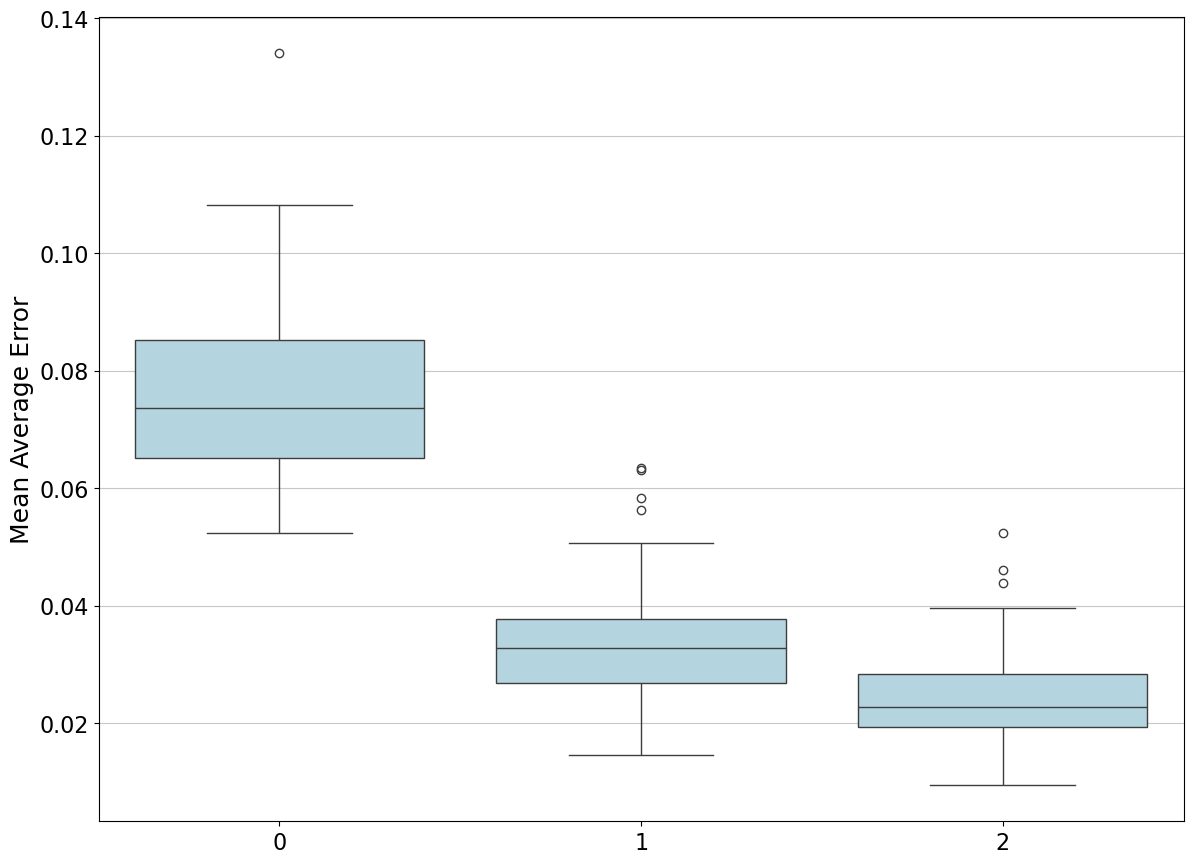

In [11]:
all_losses_x10_l1 = [arr  for arr in all_losses_l1]
# all_losses_x10_l1 = all_losses_x10_l1[::-1]
# all_losses_x10_mse = all_losses_x10_mse[::-1]

# Number of predictions (for figure height scaling)
n_preds = 1

# Style settings
mpl.rcParams.update({
    'text.usetex': False,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 20,
    'font.size': 18,
    'axes.grid': True,
    'grid.linestyle': '-',
    'grid.alpha': 0.7,
    'lines.linewidth': 1.5,
    'figure.figsize': [14, 5.5 * (n_preds + 0.9)],  # width fixed, height scales
})

# Example data (scaled by 10)
np.random.seed(0)


# Create side-by-side subplots
fig, axes = plt.subplots(1, 1, sharey=False)  # sharey makes them comparable

# Left subplot
sns.boxplot(data=[all_losses_x10_l1[1],all_losses_x10_l1[2],all_losses_x10_l1[0]], color='lightblue', ax=axes)
axes.set_xticks(range(3))
# axes.set_xticklabels([])
# axes.set_title("")
axes.set_ylabel("Mean Average Error")
# axes.set_xlabel(r"Amount of data")

